In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
from io import BytesIO
from IPython.display import display
import statsmodels.api as sm
import os
from datetime import datetime
from PIL import Image
import shutil
import string
from functions import functions 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib
from sklearn.ensemble import RandomForestClassifier


In [2]:
def algorithm_analyze(code_str, input_type):

    pol_degree = 4

    def get_function_object(code_str):
        local_scope = {}
        
        # Execute the function definon in a scope where it can recursively reference itself
        exec(code_str, local_scope, local_scope)  # Using local_scope as both global and local scope
        
        func_name = next(key for key, value in local_scope.items() if callable(value))
        algorithm = local_scope[func_name]
        
        return algorithm



    def get_graph(function, input_type):
        if input_type == 'array':
            sizes, test_input = array_input()
            
        if input_type == 'matrix':
            sizes, test_input = matrix_input()

        if input_type == 'string with letters only':
            sizes, test_input = letter_string_input()

        if input_type == 'string with all characters':
            sizes, test_input = all_string_input()

        if input_type == 'plain graph matrix':
            sizes, test_input = graph_matrix_input()
            
        times = measure_times(function, test_input)

            # Fit a polynomial curve to the data
        coefficients = np.polyfit(sizes, times, deg=pol_degree)  # Degree 4 polynomial
        poly = np.poly1d(coefficients)

        # Generate smooth data for the fitted curve
        smooth_sizes = np.linspace(min(sizes), max(sizes), 500)  # Smooth sizes from min to max size
        smooth_times = poly(smooth_sizes)  # Evaluate polynomial

        plt.figure()
        plt.plot(sizes, times, 'o', markersize=3, label='Original Data', color='white')  # Original data points
        plt.plot(smooth_sizes, smooth_times, 'r-', label='Fitted Curve')  # Fitted curve
        plt.axis('off')  # Hide the axes

        # Save the plot to a BytesIO stream
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
        plt.close()  # Close the figure to free memory
        buf.seek(0)  # Rewind your buffer
        return buf, coefficients.tolist()
    


    def array_input(n_size=700, a_size=500):
        sizes = list(range(1, n_size))
        test_lists = []

        for size in sizes:
            test_list = [random.randint(0, a_size) for _ in range(size)]
            test_lists.append(test_list)

        return sizes, test_lists
    
    def matrix_input(n_size=500, a_size=200):
        sizes = list(range(1, n_size))
        test_matrices = []

        for size in sizes:
            test_matrix = [[random.randint(0, a_size) for _ in range(size)] for _ in range(size)]
            test_matrices.append(test_matrix)
        
        return sizes, test_matrices
    
    def graph_matrix_input(n_size=500, a_size=1):
        sizes = list(range(1, n_size))
        test_matrices = []

        for size in sizes:
            test_matrix = [[random.randint(0, a_size) for _ in range(size)] for _ in range(size)]
            test_matrices.append(test_matrix)
        
        return sizes, test_matrices
    
    def letter_string_input(n_size=5000):
        sizes = list(range(1, n_size))
        test_strings = []

        for size in sizes:
            test_string = ''.join([random.choice('abcdefghijklmnopqrstuvwxyz') for _ in range(size)])
            test_strings.append(test_string)
        
        return sizes, test_strings
    
    def all_string_input(n_size=5000):
        char_pool = string.ascii_letters + string.digits + string.punctuation
        sizes = list(range(1, n_size))
        test_strings = []

        for size in sizes:
            test_string = ''.join(random.choice(char_pool) for _ in range(size))
            test_strings.append(test_string)

        return sizes, test_strings

    def measure_times(function, test_input):
        times = []

        for test_list in test_input:
            start_time = time.perf_counter()
            function(test_list)
            end_time = time.perf_counter()

            elapsed_time = end_time - start_time
            times.append(elapsed_time)

        return times

    
    algorithm = get_function_object(code_str)
    buf, coefficients = get_graph(algorithm, input_type)
    return buf, coefficients



In [3]:
def algorithm_analyze_no_img(code_str, input_type):

    pol_degree = 4

    def get_function_object(code_str):
        local_scope = {}
        
        # Execute the function definon in a scope where it can recursively reference itself
        exec(code_str, local_scope, local_scope)  # Using local_scope as both global and local scope
        
        func_name = next(key for key, value in local_scope.items() if callable(value))
        algorithm = local_scope[func_name]
        
        return algorithm



    def get_graph(function, input_type):
        if input_type == 'array':
            sizes, test_input = array_input()
            
        if input_type == 'matrix':
            sizes, test_input = matrix_input()

        if input_type == 'string with letters only':
            sizes, test_input = letter_string_input()

        if input_type == 'string with all characters':
            sizes, test_input = all_string_input()

        if input_type == 'plain graph matrix':
            sizes, test_input = graph_matrix_input()
            
        times = measure_times(function, test_input)

            # Fit a polynomial curve to the data
        coefficients = np.polyfit(sizes, times, deg=pol_degree)  # Degree 4 polynomial
    
        return coefficients.tolist()
    


    def array_input(n_size=900, a_size=200):
        sizes = list(range(1, n_size))
        test_lists = []

        for size in sizes:
            test_list = [random.randint(0, a_size) for _ in range(size)]
            test_lists.append(test_list)

        return sizes, test_lists
    
    def matrix_input(n_size=500, a_size=200):
        sizes = list(range(1, n_size))
        test_matrices = []

        for size in sizes:
            test_matrix = [[random.randint(0, a_size) for _ in range(size)] for _ in range(size)]
            test_matrices.append(test_matrix)
        
        return sizes, test_matrices
    
    def graph_matrix_input(n_size=500, a_size=1):
        sizes = list(range(1, n_size))
        test_matrices = []

        for size in sizes:
            test_matrix = [[random.randint(0, a_size) for _ in range(size)] for _ in range(size)]
            test_matrices.append(test_matrix)
        
        return sizes, test_matrices
    
    def letter_string_input(n_size=5000):
        sizes = list(range(1, n_size))
        test_strings = []

        for size in sizes:
            test_string = ''.join([random.choice('abcdefghijklmnopqrstuvwxyz') for _ in range(size)])
            test_strings.append(test_string)
        
        return sizes, test_strings
    
    def all_string_input(n_size=5000):
        char_pool = string.ascii_letters + string.digits + string.punctuation
        sizes = list(range(1, n_size))
        test_strings = []

        for size in sizes:
            test_string = ''.join(random.choice(char_pool) for _ in range(size))
            test_strings.append(test_string)

        return sizes, test_strings

    def measure_times(function, test_input):
        times = []

        for test_list in test_input:
            start_time = time.perf_counter()
            function(test_list)
            end_time = time.perf_counter()

            elapsed_time = end_time - start_time
            times.append(elapsed_time)

        return times

    
    algorithm = get_function_object(code_str)
    coefficients = get_graph(algorithm, input_type)
    return coefficients



In [4]:
def save_algorithm_output(code_str, input_type, complexity_type, repeat):
    # Ensure the directory exists
    images_dir = f'images3/{complexity_type}'
    os.makedirs(images_dir, exist_ok=True)  # Creates the directory if it doesn't exist
    
    csv_path = 'features3.csv'
    
    # Initialize a DataFrame to collect all coefficients and file paths
    all_coefficients = pd.DataFrame()
    
    # Process and save each output
    for i in range(repeat):
        image_bytes, coefficients = algorithm_analyze(code_str, input_type)
        
        # Create a unique timestamp
        timestamp = datetime.now().strftime('%Y%m%d%H%M%S%f')
        
        # Save image with a unique timestamp in the filename
        image_filename = f"{images_dir}/image_{timestamp}.png"
        with open(image_filename, 'wb') as f:
            f.write(image_bytes.getbuffer())
        
        # Convert coefficients to DataFrame, ensuring they're labeled correctly
        # Here we dynamically create column names based on the length of coefficients list
        coeff_columns = [f'Coeff_{j}' for j in range(len(coefficients))]
        df = pd.DataFrame([coefficients], columns=coeff_columns)
        df['ImageFile'] = image_filename  # Track image file name
        
        df['Complexity_Type'] = complexity_type
        # Append the current row of coefficients to the all_coefficients DataFrame
        all_coefficients = pd.concat([all_coefficients, df], ignore_index=True)
    
    # Save or append the coefficients data to CSV
    if os.path.exists(csv_path):
        all_coefficients.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        all_coefficients.to_csv(csv_path, mode='w', index=False)

    return all_coefficients  # Optional: return DataFrame for further processing or inspection

# Example call (You need to define or adjust `algorithm_analyze` as per your actual implementation)
# save_algorithm_output('some_code_str', 'type1', 'simple', 10)


In [5]:
def save_algorithm_output_no_img(code_str, input_type, complexity_type, repeat):
    csv_path = 'features.csv'
    
    # Initialize a DataFrame to collect all coefficients, complexity types, and file paths
    all_coefficients = pd.DataFrame()
    
    # Process and save each output
    for i in range(repeat):
        coefficients = algorithm_analyze_no_img(code_str, input_type)
        
        # Convert coefficients to DataFrame, ensuring they're labeled correctly
        # Here we dynamically create column names based on the length of coefficients list
        coeff_columns = [f'Coeff_{j}' for j in range(len(coefficients))]
        df = pd.DataFrame([coefficients], columns=coeff_columns)
        
        # Add complexity type to each row in the DataFrame
        df['Complexity_Type'] = complexity_type
        
        # Append the current row of coefficients and complexity type to the all_coefficients DataFrame
        all_coefficients = pd.concat([all_coefficients, df], ignore_index=True)
    
    # Save or append the coefficients data to CSV
    if os.path.exists(csv_path):
        all_coefficients.to_csv(csv_path, mode='a', header=False, index=False)
    else:
        all_coefficients.to_csv(csv_path, mode='w', index=False)

    return all_coefficients  # Optional: return DataFrame for further processing or inspection

# Example call (You need to define or adjust `algorithm_analyze` as per your actual implementation)
# save_algorithm_output_no_img('some_code_str', 'type1', 'simple', 10)


In [6]:
def clean_images():
    directory= 'images3'
    # Loop through all items in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            # If it's a file or directory, remove it
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and its contents
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

def clear_csv_file():
    file_path = 'features3.csv'
    # Open the file in write mode which will truncate the file (set it to empty)
    with open(file_path, 'w', newline='') as csv_file:
        pass

In [7]:
func_type = 'constant'
input_type = 'array'
index = 0
function_x = functions[func_type][input_type][index]
function_x



'\ndef constant_function1(arr):\n    return 42\n'

In [53]:
function_x = """
def find_peak(arr):
    low = 0
    high = len(arr) - 1
    
    while low <= high:
        mid = (low + high) // 2
        
        # If mid is a peak element, return it
        if (mid == 0 or arr[mid] >= arr[mid - 1]) and (mid == len(arr) - 1 or arr[mid] >= arr[mid + 1]):
            return arr[mid]
        
        # If the left neighbor is greater, move to the left half
        elif mid > 0 and arr[mid - 1] > arr[mid]:
            high = mid - 1
        
        # Otherwise, move to the right half
        else:
            low = mid + 1
"""

## Diplay and generate data

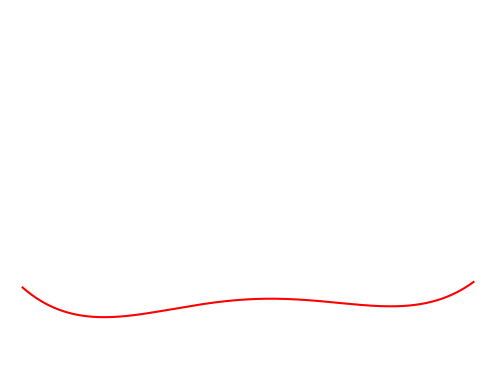

Coefficients: [6.713735116161553e-17, -9.699410941326466e-14, 4.58893345249011e-11, -7.522711056081543e-09, 1.0549854147656279e-06]
<class '_io.BytesIO'>


In [63]:
buf, coefficients = algorithm_analyze(function_x, input_type)
image = Image.open(buf)

# Display the image in the notebook
display(image)
print("Coefficients:", coefficients)
print(type(buf))

In [10]:
# coefficients = algorithm_analyze_no_img(function_x, input_type)

# print("Coefficients:", coefficients)


## Generate and save data for training

In [11]:
#save_algorithm_output(function_x, 'array', func_type,  1)

## Delete generated data

In [12]:
#clean_images()

In [13]:
#clear_csv_file()

## Generate 1000 data units

In [14]:
# for func_type in functions:
#     #print(func_type)
#     for input_type in functions[func_type]:
#         #print(input_type)
#         for function_x in functions[func_type][input_type]:
#             #print(function_x[0:15])
#             save_algorithm_output(function_x, input_type, func_type, 20)

        

## ML model


In [56]:
file = 'features.csv'
df = pd.read_csv(file, header=None)

df.head()

,0,1,2,3,4,5,6
0,8.787202e-18,-1.431882e-14,8.023825e-12,-1.781098e-09,2.285184e-07,images/constant/image_20240915112800213730.png,constant
1,2.466732e-18,-4.939054e-15,3.328776e-12,-8.572360e-10,1.618702e-07,images/constant/image_20240915112800397076.png,constant
2,3.753142e-18,-6.901179e-15,4.375719e-12,-1.099449e-09,1.859992e-07,images/constant/image_20240915112800561701.png,constant
3,8.760796e-18,-1.381433e-14,7.511366e-12,-1.633264e-09,2.109026e-07,images/constant/image_20240915112800733994.png,constant
4,3.937954e-18,-6.852378e-15,4.030102e-12,-9.024813e-10,1.624399e-07,images/constant/image_20240915112800889651.png,constant


In [57]:
X = df.iloc[:, :-2].values  
y = df.iloc[:, -1].values 

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_encoded, test_size=0.2)


In [58]:
random_forest_model = RandomForestClassifier(n_estimators=500)

# Train the model
random_forest_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test)

# Output probabilities for each class (optional)
y_pred_proba = random_forest_model.predict_proba(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.98
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       0.97      0.97      0.97        40
           2       0.97      0.97      0.97        34
           3       0.98      0.98      0.98        46
           4       0.98      0.98      0.98        45

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [59]:
joblib.dump(random_forest_model, 'random_forest_model.pkl')

# Save the label encoder to decode predicted labels later
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [60]:
buf, coefficients = algorithm_analyze(function_x, input_type)

In [66]:
loaded_model = joblib.load('random_forest_model.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Example new data point (replace with actual values you want to predict)
new_data = [coefficients]  # Example features
# Normalize the new data point (same normalization process as training data)
new_data_normalized = scaler.transform(new_data)

# Predict the class probabilities for the new data point
predicted_probabilities = loaded_model.predict_proba(new_data_normalized)

# Predict the class for the new data point
predicted_class = loaded_model.predict(new_data_normalized)

# Decode the predicted class back to its original label
predicted_label = label_encoder.inverse_transform(predicted_class)
print(label_encoder.classes_)
# Output the predicted label and probabilities
print("Predicted Class:", predicted_label[0])
print("Class Probabilities:", predicted_probabilities)

['constant' 'linear' 'log(n)' 'nlog(n)' 'polynomial']
Predicted Class: log(n)
Class Probabilities: [[0.032 0.098 0.87  0.    0.   ]]
